## Airbnb project

In [387]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import seaborn as sns
import numpy as np
import shapely
from geopy import distance

In [388]:
pd.options.mode.chained_assignment = None

In [389]:
#hood = gpd.read_file('neighbourhoods.geojson')
metro = gpd.read_file('metro.geojson')
df = pd.read_csv('listings.csv')

C:\Users\raffa\anaconda3\lib\site-packages\geopandas\geodataframe.py:35: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


# Metro dataset

In [390]:
df2 = metro.copy()
for i in range(len(df2)):
    if not '/' in df2['LINHA'][i]:
        df2.drop([i], axis=0, inplace=True)
df2 = df2.reset_index()

In [391]:
for i in range(len(metro)):
    if '/' in  metro['LINHA'][i]:
        metro['LINHA'][i] = metro['LINHA'][i].split('/')[0]

for j in range(len(df2)):
    df2['LINHA'][j] = df2['LINHA'][j].split('/')[1]
    
metro = pd.concat([metro, df2])

In [392]:
metro = pd.concat([metro, df2])
metro = metro.drop(columns = ['index','OBJECTID','COD_SIG','IDTIPO','SITUACAO','GlobalID'])

In [393]:
metro

,NOME,LINHA,geometry
0,Cais do Sodré,Verde,POINT (-9.14609 38.70627)
1,Terreiro do Paço,Azul,POINT (-9.13419 38.70728)
2,Baixa Chiado,Azul,POINT (-9.14015 38.71057)
3,Santa Apolónia,Azul,POINT (-9.12241 38.71404)
4,Rossio,Verde,POINT (-9.13792 38.71418)
...,...,...,...
1,Marquês de Pombal,Amarela,POINT (-9.15005 38.72532)
2,São Sebastião,Vermelha,POINT (-9.15394 38.73453)
3,Saldanha,Vermelha,POINT (-9.14533 38.73532)
4,Alameda,Vermelha,POINT (-9.13387 38.73697)


In [394]:
yellow = metro[metro.LINHA == 'Amarela'].reset_index()
blue = metro[metro.LINHA == 'Azul'].reset_index()
green = metro[metro.LINHA == 'Verde'].reset_index()
red = metro[metro.LINHA == 'Vermelha'].reset_index()

# Metro Network

In [395]:
import networkx as nx
from pyvis.network import Network

Import the graph baseline from excel where we have column for Origin and Destination

In [396]:
metro_graph = pd.read_excel('metro.xlsx')

In [397]:
metro_graph = metro_graph.dropna()
metro_graph = metro_graph.drop(columns = ['NOME', 'LINHA', 'Unnamed: 0', 'OBJECTID'])

## Set up the graph

In [398]:
G = nx.Graph()
G = nx.from_pandas_edgelist(metro_graph, 'Origin', 'Destination')

In [399]:
net = Network(notebook=True)
net.from_nx(G)
net.width=500
net.height=500
net.show('metro.html')

Get the origin and destination coordinates

In [400]:
metro_dict = dict(zip(metro.NOME, metro.geometry))
metro_graph['p1'] = (metro_graph['Origin']).map(metro_dict)
metro_graph['p2'] = (metro_graph['Destination']).map(metro_dict)

C:\Users\raffa\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Create a LineString object between origin and Destination

In [401]:
a = []
for i in range(len(metro_graph)):
    a.append((LineString([metro_graph.p1[i],metro_graph.p2[i]])))

metro_graph['LineString'] = a

Transform the graph in a Geopandas Datframe

In [402]:
metro_graph = gpd.GeoDataFrame(metro_graph)

## Calculate distance between nodes

In [403]:
from shapely.geometry import LineString
from shapely.ops import transform
from functools import partial
import pyproj

This function transforms the LineString distance in Meters

In [404]:
def transform_linestring(df):
    
    lenghts = []
    project = partial(pyproj.transform, pyproj.Proj('EPSG:4326'), pyproj.Proj('EPSG:32633'))
    for line in df.LineString:
        lenghts.append(int(transform(project, line).length))
    
    df['distance_meters'] = lenghts

In [405]:
transform_linestring(metro_graph)

We now have a graph with a distance attribute to calculate degree importance based on.

In [406]:
G_distance = nx.from_pandas_edgelist(metro_graph, 'Origin', 'Destination',['distance_meters'])

### Degrees

In [407]:
#degree_sort = sorted(G_distance.degree(), key=lambda x: x[1], reverse=True)
degrees = {node:val for (node, val) in G_distance.degree()}

closeness = nx.closeness_centrality(G_distance, distance='distance_meters')

between = nx.betweenness_centrality(G_distance, weight='distance_meters')

eigen = nx.eigenvector_centrality(G_distance,max_iter=10000, weight='distance_meters')

centrality = nx.degree_centrality(G_distance)

In [408]:
betweness = pd.DataFrame.from_dict(between, orient='index').rename(columns = {0: 'Betweness'}).reset_index().rename(columns = {'index': 'station'})
closeness = pd.DataFrame.from_dict(closeness, orient='index').rename(columns = {0: 'Closeness'}).reset_index().rename(columns = {'index': 'station'})
eigeness = pd.DataFrame.from_dict(eigen, orient='index').rename(columns = {0: 'Eigeness'}).reset_index().rename(columns = {'index': 'station'})
central = pd.DataFrame.from_dict(centrality, orient='index').rename(columns = {0: 'Centrality'}).reset_index().rename(columns = {'index': 'station'})
Degree = pd.DataFrame.from_dict(degrees, orient='index').rename(columns = {0: 'Degree'}).reset_index().rename(columns = {'index': 'station'})
weight = pd.merge(betweness, closeness, on='station')
weight = pd.merge(weight, eigeness, on='station')
weight = pd.merge(weight, central, on='station')
weight = pd.merge(weight, Degree, on='station')

In [409]:
weight['degree_mean'] = weight.iloc[:,1:4].mean(axis=1)

In [410]:
lines_dict = dict(zip(metro.NOME, metro.LINHA))
station_coord = dict(zip(metro.NOME, metro.geometry))

weight['line_color'] = (weight['station']).map(lines_dict)
weight['Coordinate'] = (weight['station']).map(station_coord)

C:\Users\raffa\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Function that gives the distance in meters from a specified point to each metro station

The idea is to have an interactive weight attribution where we are the ones choosing the point of interest, giving coordinates which can be found on this website: https://www.latlong.net/place/rossio-square-lisbon-portugal-23131.html.
Then we assign a score to that monument and depending on how near the metro station is the more importance it gets.

In [76]:
def distance_grade(longlat_tuple, grade, df, name_of_place):
    
    col_name = 'Distance from ' + str(name_of_place)
    
    from_place_list = [] #list of distances
    location = Point(longlat_tuple) #get location of the monument
    project = partial(pyproj.transform, pyproj.Proj('EPSG:4326'), pyproj.Proj('EPSG:32633'))
    for i in df.Coordinate: #iterate over the coordinates of each metro station
        line_string = shapely.geometry.LineString([i,location]) #construct a linestring between the station and the monument
        trans = transform(project, line_string) #transform the linestring in meters
        #from_place_list.append(int(trans.length))
        
    #further implementation to assign weight (importance) to each monument
        if int(trans.length) < 2000: #if the distance is less than 4 km from the monument
            from_place_list.append(grade) 
        elif int(trans.length) < 4000 and int(trans.length) > 2000:
            from_place_list.append(grade*0.5)
        elif int(trans.length) < 8000 and int(trans.length) > 4000:
            from_place_list.append(grade*0.25)
        else:
            from_place_list.append(0)
            
    df[col_name] = from_place_list

## Implement for a list of monuments

In [368]:
list_of_monuments = {'Mosteiro dos Jerónimos': ((-9.204487, 38.697819), 1),
                    'Oceanário de Lisboa': ((-9.0937, 38.7635), 1),
                    'Museu Nacional de Arte Antiga': ((-9.141161, 38.708460), 1),
                    'Torre de Belem': ((-9.2147, 38.6967), 1),
                    'Elevador de Santa Justa': ((-9.139221, 38.712173), 1),
                    'Padrão dos Descobrimentos': ((-9.205712, 38.693596), 1),
                    'Praça do Comércio': ((-9.136744, 38.707779), 1),
                    'Museu de Arte, Arquitectura e Tecnologia': ((-9.194453, 38.695927), 1)     
                    }

In [369]:
list(list_of_monuments.values())[0][0]

(-9.204487, 38.697819)

In [370]:
for i in list_of_monuments:
    distance_grade(list_of_monuments[i][0], list_of_monuments[i][1], weight, i)

In [80]:
weight['Monument_Score'] = weight.iloc[:,9:].mean(axis=1).round(2)

## Delete columns in excess

In [81]:
weight = weight.drop(columns = weight.iloc[:,9:-1].columns.tolist())
weight = weight.drop(columns = weight.iloc[:,1:4].columns.tolist())

In [82]:
weight

,station,Centrality,Degree,degree_mean,line_color,Coordinate,Monument_Score
0,Reboleira,0.020408,1,0.000030,Azul,POINT (-9.22388329557507 38.752271287954),0.12
1,Amadora Este,0.040816,2,0.013646,Azul,POINT (-9.21790161711738 38.758715859802),0.09
2,Alfornelos,0.040816,2,0.026693,Azul,POINT (-9.20447747827746 38.7605071115253),0.09
3,Pontinha,0.040816,2,0.039180,Azul,POINT (-9.19693737461709 38.7623917163549),0.06
4,Carnide,0.040816,2,0.051157,Azul,POINT (-9.19273248473962 38.7591726199562),0.09
5,Colégio Militar,0.040816,2,0.062748,Azul,POINT (-9.18982582843268 38.7538737032722),0.16
6,Alto dos Moinhos,0.040816,2,0.073904,Azul,POINT (-9.18055368307301 38.7501358045407),0.22
7,Laranjeiras,0.040816,2,0.084964,Azul,POINT (-9.17248892825242 38.7486544474615),0.19
8,Jardim Zoológico,0.040816,2,0.096579,Azul,POINT (-9.16832747191897 38.7413650553712),0.22
9,Praça de Espanha,0.040816,2,0.109039,Azul,POINT (-9.15932888063129 38.7378628556453),0.22


## Score increase based on Degree

If the metro station has more than degree 2 i.e. it's a crossing of 2 lines: the score is increased by 50%.

In [41]:
for i in range(len(weight)):
    if weight.Degree[i] > 2:
        weight.Monument_Score[i] *= 1.5

In [42]:
weight

,station,Centrality,Degree,degree_mean,line_color,Coordinate,Monument_Score
0,Reboleira,0.020408,1,0.000030,Azul,POINT (-9.22388329557507 38.752271287954),0.800
1,Amadora Este,0.040816,2,0.013646,Azul,POINT (-9.21790161711738 38.758715859802),0.610
2,Alfornelos,0.040816,2,0.026693,Azul,POINT (-9.20447747827746 38.7605071115253),0.610
3,Pontinha,0.040816,2,0.039180,Azul,POINT (-9.19693737461709 38.7623917163549),0.360
4,Carnide,0.040816,2,0.051157,Azul,POINT (-9.19273248473962 38.7591726199562),0.610
5,Colégio Militar,0.040816,2,0.062748,Azul,POINT (-9.18982582843268 38.7538737032722),1.080
6,Alto dos Moinhos,0.040816,2,0.073904,Azul,POINT (-9.18055368307301 38.7501358045407),1.520
7,Laranjeiras,0.040816,2,0.084964,Azul,POINT (-9.17248892825242 38.7486544474615),1.270
8,Jardim Zoológico,0.040816,2,0.096579,Azul,POINT (-9.16832747191897 38.7413650553712),1.520
9,Praça de Espanha,0.040816,2,0.109039,Azul,POINT (-9.15932888063129 38.7378628556453),1.550


In [164]:
list_of_monuments_2= {'Elevador de Santa Justa': ((-9.139221, 38.712173), 1),
                    'Praça do Comércio': ((-9.136744, 38.707779), 1),
                     'Marques d Pobal' : ((-9.149809571870293, 38.72520372326393 ),1),
                     'Praca dom luois I' : (( -9.14651051085467, 38.70696585893371),1),
                     'Jardim Guerra Junqueiro (Jardim da Estrela)' : ((-9.157568180154488, 38.715165895486756),1),
                     'Miradouro de São Pedro de Alcântara' : ((-9.144383380607636, 38.714999758691214 ), 1),
                     'Assembly of the Republic' : (( -9.154170376301336, 38.71222285831986),1)
                     }

In [165]:
len(list(list_of_monuments_2.values()))

7

In [411]:
#sorting dataset based on houses average distances from points of interest
#slicing dataset on house type

df_red=df[df['price']<150]
df_red_apt=df_red[df_red['room_type']=='Entire home/apt']
df_red_rooms=df_red[df_red['room_type']=='Private room']
df_red_hotel=df_red[df_red['room_type']=='Hotel room']
df_red_shared=df_red[df_red['room_type']=='Shared room']

In [412]:
import geopy
def house_avg_distance(monuments, houses,j):  #computing average distance between a given house and every given point of interest
    tot_dist=0
    for i in range(len(monuments)):
        coord_1=(list(monuments.values())[i][0][1],list(monuments.values())[i][0][0])
        coord_2=(houses.latitude[j],houses.longitude[j])
        distance=geopy.distance.distance(coord_1, coord_2).km
        tot_dist=tot_dist+distance
    avg_dst=(tot_dist/len(monuments))*10
    
    return(avg_dst)   
    
    

In [413]:
#computing average distance form points of interest for each house in the dataset
def distances(houses, monuments):
    avg_distances_list=[]   
    for i in range(len(houses)):
        avg_distances=house_avg_distance(monuments,df,i)
        avg_distances_list.append(avg_distances)
    houses['avg interest points-house distance'] = avg_distances_list

In [415]:
distances(df_red_apt, list_of_monuments_2)
distances(df_red_rooms, list_of_monuments_2)
distances(df_red_hotel, list_of_monuments_2)
distances(df_red_shared, list_of_monuments_2)

In [416]:
df_red_apt[df_red_apt['avg interest points-house distance']<20]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,avg interest points-house distance
1,25659,Heart of Alfama Lisbon Center - Cœur de l'Alfama,107347,Ellie,Lisboa,Santa Maria Maior,38.712410,-9.127060,Entire home/apt,50,2,127,2021-11-27,1.37,1,325,14,56539/AL.,18.342461
2,29248,Apartamento Alfama com vista para o rio!,125768,Bárbara,Lisboa,Santa Maria Maior,38.710820,-9.127190,Entire home/apt,60,5,337,2021-12-03,2.53,1,190,13,23535/AL,18.321832
3,29396,Alfama Hill - Boutique apartment,126415,Mónica,Lisboa,Santa Maria Maior,38.711560,-9.129870,Entire home/apt,60,2,299,2021-12-03,2.57,1,302,40,28737/AL,16.084885
5,29915,Modern and Cool Apartment in Lisboa,128890,Sara,Lisboa,Avenidas Novas,38.745710,-9.152640,Entire home/apt,50,5,46,2021-10-20,0.33,1,228,8,85851/AL.,13.245617
9,48025,Apartment for renting in Lisbon,218778,José,Lisboa,Misericrdia,38.711950,-9.144630,Entire home/apt,65,5,18,2020-09-10,0.14,6,261,0,66950/AL,9.204878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18485,53581011,ALTIDO Modern 2-Level Flat w/Balcony & Terrace,1756107,Altido,Lisboa,Ajuda,38.706787,-9.190212,Entire home/apt,102,3,0,NaN,NaN,151,360,0,121293/AL,19.711152
18490,53585751,Santa Clara Pateo,70305938,Paula,Lisboa,So Vicente,38.717216,-9.123561,Entire home/apt,79,2,0,NaN,NaN,8,353,0,48086/AL,12.345781
18513,53672264,Alcantara Terrace by GT House,71962548,GT House,Lisboa,Alcntara,38.703900,-9.189750,Entire home/apt,59,1,0,NaN,NaN,24,357,0,88762/AL,19.846817
18522,53715760,Zen Nest in the heart of Lisbon,236728213,Carolina,Lisboa,Santo Antnio,38.721587,-9.143302,Entire home/apt,40,5,0,NaN,NaN,1,95,0,Exempt,13.431954


In [150]:
df_red_rooms.room_type.iloc[0]


'Private room'

In [151]:
#generates scatter plot for every sub_dataset provided to the function
def plot_gen(df):
    x=df['avg interest points-house distance']
    y=df['price']
    plt.scatter(x, y)
    plt.title(f'relation between distance from points of interest and price for {df.room_type.iloc[0]}')
    plt.xlabel('avg distance')
    plt.ylabel('price')
    plt.show()

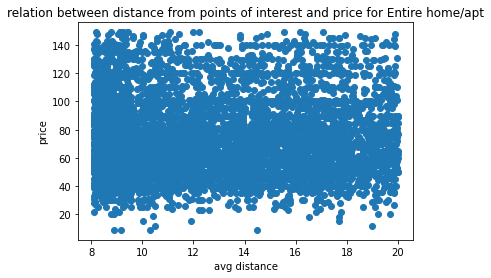

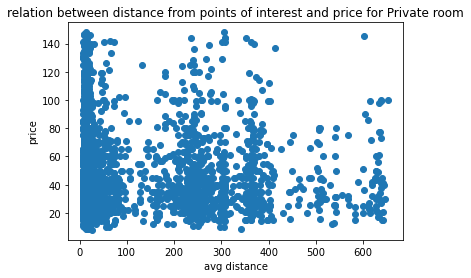

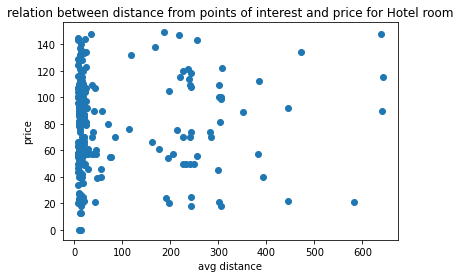

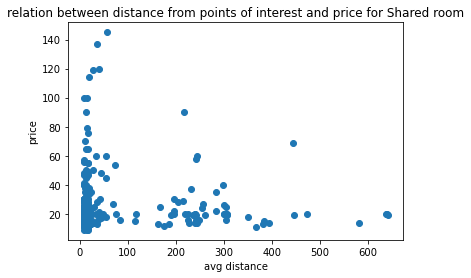

In [184]:
#scatter plots of every sub_dataset representing relation between price and average distance form points of interest
#in some of them we can already see a bit of a correlation between distance from points of interest and price.
plot_gen(df_red_apt[df_red_apt['avg interest points-house distance']<20])
plot_gen(df_red_rooms)
plot_gen(df_red_hotel)
plot_gen(df_red_shared)

In [185]:
#showing current correlation between average distances and prices, we should choose more accurately the list of points of interest to consider, and then i think 
#he value of these correlation will increase, we should also.. probably more importantly compute regressions coefficients of the aforemetioned variables
#once that is done we can proceede to strip the component of house price that is given by the distance from points of interest and assume the remaining part 
#is given by the distance from metro stations.
correlations={'correlation for apt' : df_red_apt['price'].corr(df_red_apt['avg interest points-house distance']),
             'correlation for rooms' : df_red_rooms['price'].corr(df_red_rooms['avg interest points-house distance']),
             'correlation for hotel' : df_red_hotel['price'].corr(df_red_hotel['avg interest points-house distance']),
             'correlation for shared rooms' : df_red_shared['price'].corr(df_red_shared['avg interest points-house distance'])}
correlations

{'correlation for apt': 0.001012911111752711,
 'correlation for rooms': 0.013140814960563863,
 'correlation for hotel': 0.08155006377765509,
 'correlation for shared rooms': -0.06682102237972119}

In [417]:
df_red_apt
df_red_apt['price'].corr(df_red_apt['avg interest points-house distance'])

0.001012911111752711

In [418]:
metro=metro.set_index('NOME')
    

In [419]:
point=metro.geometry[0]

In [420]:
x=point.x
y=point.y
type(x)

float

In [421]:
coord_1=(y, x)
coord_2=(df_red_apt.latitude[0],df_red_apt.longitude[0])
distance=geopy.distance.distance(coord_1, coord_2).km
distance

4.591999887303074

In [422]:
metro

,LINHA,geometry
NOME,,
Cais do Sodré,Verde,POINT (-9.14609 38.70627)
Terreiro do Paço,Azul,POINT (-9.13419 38.70728)
Baixa Chiado,Azul,POINT (-9.14015 38.71057)
Santa Apolónia,Azul,POINT (-9.12241 38.71404)
Rossio,Verde,POINT (-9.13792 38.71418)
...,...,...
Marquês de Pombal,Amarela,POINT (-9.15005 38.72532)
São Sebastião,Vermelha,POINT (-9.15394 38.73453)
Saldanha,Vermelha,POINT (-9.14533 38.73532)


In [381]:
list(list_of_monuments.keys())[0]

'Mosteiro dos Jerónimos'

In [423]:
#finds the closest metro station and the distance from it 
def closest_metro_station_finder(metro, houses, j):
    dist_stat=[]
    h_m_dist={}
    for i in range(len(metro)):
            point=metro.geometry[i]
            x=point.y
            y=point.x
            coord_1=(x, y)
            coord_2=(houses.latitude.iloc[j], houses.longitude.iloc[j])
            distance=geopy.distance.distance(coord_1, coord_2).km
            h_m_dist[metro.index[i]]=distance
    h_m_v=list(h_m_dist.values())
    h_m_k=list(h_m_dist.keys())
    closest_st=min(h_m_v)
    ind=h_m_v.index(closest_st)
    station=h_m_k[ind]
    dist_stat.append(closest_st)
    dist_stat.append(station)
    return dist_stat

In [429]:
#using function above to find closest metro station and relative distance from every house in the subdataset containing shared bedrooms only
distances=[]
stations=[] 
for i in range(len(df_red_shared)):
    new_list=house_metro_distance(metro, df_red_shared, i)
    distances.append(new_list[0])
    stations.append(new_list[1])
df_red_shared['closest station']=stations
df_red_shared['distance from closest station']=distances

In [430]:
df_red_shared

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,avg interest points-house distance,closest station,distance from closest station
117,286153,Shared appartment - double room2,1489229,João,Lisboa,Campolide,38.728510,-9.166440,Shared room,20,...,49,2020-09-24,0.41,2,310,0,Registo como alojamento local no turismo de Po...,48.089863,Praça de Espanha,1.208433
448,942510,Underdog Surf House - Male shared room,455096,Daniel (Underdog Surf House),Lourinh,Lourinh e Atalaia,39.264230,-9.331120,Shared room,21,...,3,2020-08-15,0.04,7,365,0,NaN,18.342461,Odivelas,54.007686
480,1026382,Underdog Surf House - Female Dorm,455096,Daniel (Underdog Surf House),Lourinh,Lourinh e Atalaia,39.265490,-9.329130,Shared room,21,...,2,2019-09-03,0.03,7,365,0,NaN,18.321832,Odivelas,54.099717
624,1365083,Mini Hostel in Lisbon. Room for 4 guests,6401752,Anna,Lisboa,Areeiro,38.738620,-9.135470,Shared room,15,...,114,2021-06-06,1.13,3,334,1,57649/AL,16.084885,Alameda,0.230324
634,1380975,Bed in a 10 mixed dorm shared wc,6855202,Lisboa Central Hostel,Lisboa,Santo Antnio,38.723720,-9.146870,Shared room,14,...,49,2021-11-07,0.74,7,357,17,11282/AL,13.245617,Marquês de Pombal,0.328256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18052,52770821,Monthly Rental - Shared Room,122481877,Joana,Cascais,Carcavelos e Parede,38.685010,-9.339320,Shared room,11,...,0,NaN,NaN,12,341,0,18040/AL,367.162084,Reboleira,12.511589
18104,52882627,N&N (quarto 1),307638833,N&N House Hospedagem,Lisboa,Arroios,38.729950,-9.135580,Shared room,19,...,2,2021-10-31,1.28,4,365,2,Exempt,18.580503,Anjos,0.313098
18105,52882736,N&N (quarto 2),307638833,N&N House Hospedagem,Lisboa,Arroios,38.735990,-9.134840,Shared room,19,...,1,2021-10-26,0.67,4,311,1,Exempt,260.236780,Alameda,0.137259
18240,53210258,Modern Space Sintra 30Min of Lisbon airport a...,278247291,Wellington Marcio De,Sintra,Massam e Monte Abrao,38.757530,-9.280750,Shared room,60,...,0,NaN,NaN,1,362,0,Exempt,54.276134,Reboleira,4.977460


In [ ]:
#using function above to find closest metro station and relative distance from every house in the subdataset containing entire apartments only
distances=[]
stations=[] 
for i in range(len(df_red_apt)):
    new_list=house_metro_distance(metro, df_red_apt, i)
    distances.append(new_list[0])
    stations.append(new_list[1])
    print (i)
df_red_apt['closest station']=stations
df_red_apt['distance from closest station']=distances

In [428]:
df_red_apt

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,avg interest points-house distance,closest station,distance from closest station
0,6499,Belém 1 Bedroom Historical Apartment,14455,Bruno,Lisboa,Belm,38.697500,-9.197680,Entire home/apt,40,...,32,2021-11-01,0.36,1,315,6,NaN,48.089863,Rato,4.503949
1,25659,Heart of Alfama Lisbon Center - Cœur de l'Alfama,107347,Ellie,Lisboa,Santa Maria Maior,38.712410,-9.127060,Entire home/apt,50,...,127,2021-11-27,1.37,1,325,14,56539/AL.,18.342461,Santa Apolónia,0.443087
2,29248,Apartamento Alfama com vista para o rio!,125768,Bárbara,Lisboa,Santa Maria Maior,38.710820,-9.127190,Entire home/apt,60,...,337,2021-12-03,2.53,1,190,13,23535/AL,18.321832,Santa Apolónia,0.548231
3,29396,Alfama Hill - Boutique apartment,126415,Mónica,Lisboa,Santa Maria Maior,38.711560,-9.129870,Entire home/apt,60,...,299,2021-12-03,2.57,1,302,40,28737/AL,16.084885,Terreiro do Paço,0.605491
5,29915,Modern and Cool Apartment in Lisboa,128890,Sara,Lisboa,Avenidas Novas,38.745710,-9.152640,Entire home/apt,50,...,46,2021-10-20,0.33,1,228,8,85851/AL.,13.245617,Entre Campos,0.417752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18521,53715663,Studio Apt. with Terrace in Historical Bairro ...,3233768,Alex,Lisboa,Misericrdia,38.711931,-9.146540,Entire home/apt,70,...,0,NaN,NaN,1,179,0,88434/AL,34.342977,Baixa Chiado,0.575944
18522,53715760,Zen Nest in the heart of Lisbon,236728213,Carolina,Lisboa,Santo Antnio,38.721587,-9.143302,Entire home/apt,40,...,0,NaN,NaN,1,95,0,Exempt,13.431954,Avenida,0.279969
18523,53717168,NEW! Charming 2 bed w/patio in historical Mour...,186259819,Isabelle,Lisboa,Santa Maria Maior,38.716469,-9.132524,Entire home/apt,75,...,0,NaN,NaN,8,258,0,68987/AL,234.224613,Martim Moniz,0.317380
18525,53723356,Alfama Top Location 2,6604033,Joao,Lisboa,Santa Maria Maior,38.715410,-9.132390,Entire home/apt,55,...,0,NaN,NaN,4,246,0,29524/AL,8.149208,Martim Moniz,0.394306


In [ ]:
#using function above to find closest metro station and relative distance from every house in the subdataset containing private rooms only
distances=[]
stations=[] 
for i in range(len(df_red_rooms)):
    new_list=house_metro_distance(metro, df_red_rooms, i)
    distances.append(new_list[0])
    stations.append(new_list[1])
    print (i)
df_red_rooms['closest station']=stations
df_red_rooms['distance from closest station']=distances

In [441]:
df_red_rooms

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,avg interest points-house distance,closest station,distance from closest station
6,33348,Happy Season,144484,Bruno,Lisboa,Lumiar,38.764270,-9.153010,Private room,40,...,2,2011-07-22,0.02,2,0,0,NaN,48.089863,Quinta das Conchas,0.418690
22,97503,Lovely equipped flat in city centre,515924,Joel,Lisboa,Santo Antnio,38.721290,-9.142200,Private room,22,...,43,2021-08-31,0.34,9,105,1,NaN,18.342461,Avenida,0.321536
27,122572,A confortable room in a nice place,614156,Isabel,Lisboa,So Domingos de Benfica,38.756430,-9.177000,Private room,62,...,0,NaN,NaN,1,0,0,NaN,18.321832,Alto dos Moinhos,0.763963
29,125835,Rent quarter,624965,Vanessa,Vila Franca De Xira,Vila Franca de Xira,38.957220,-9.002640,Private room,50,...,0,NaN,NaN,1,365,0,NaN,16.084885,Moscavide,21.994327
31,126646,"Room and balcony in house, overlooking the ""Ta...",628095,Filipe,Lisboa,Penha de Frana,38.729830,-9.131830,Private room,26,...,292,2021-11-22,3.27,3,87,36,Exempt,13.245617,Anjos,0.393669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18500,53624014,QUARTO CENTRAL 3,55746040,Oscar,Lisboa,Arroios,38.720316,-9.138376,Private room,20,...,0,NaN,NaN,4,345,0,55240/AL,366.268661,Martim Moniz,0.361585
18509,53657807,Alojamento Local pequeno almoço e estacionamento,434525149,Miguel,Vila Franca De Xira,Pvoa de Santa Iria e Forte da Casa,38.884990,-9.048350,Private room,55,...,0,NaN,NaN,1,364,0,121369/AL,365.241800,Moscavide,13.070867
18516,53684586,Carcavelos Beach walking distance room,70282462,Fernanda,Oeiras,"Oeiras e S.Julio da Barra, Pao de Arcos e Caxias",38.682760,-9.322510,Private room,35,...,0,NaN,NaN,12,62,0,108227/AL,367.958439,Reboleira,11.537673
18519,53702623,Quarto aeroporto,228781046,Priscila,Loures,Sacavm e Prior Velho,38.791987,-9.122908,Private room,28,...,0,NaN,NaN,5,343,0,Exempt,365.835396,Encarnação,1.974775


In [ ]:
#using function above to find closest metro station and relative distance from every house in the subdataset containing hotel rooms only
distances=[]
stations=[] 
for i in range(len(df_red_hotel)):
    new_list=house_metro_distance(metro, df_red_hotel, i)
    distances.append(new_list[0])
    stations.append(new_list[1])
    print (i)
df_red_hotel['closest station']=stations
df_red_hotel['distance from closest station']=distances

In [439]:
df_red_hotel

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,avg interest points-house distance,closest station,distance from closest station
713,1617589,Quarto Duplo com vista - Sintra Small Hostel,8595443,Jorge,Sintra,"S.Maria, S.Miguel, S.Martinho, S.Pedro Penaferrim",38.79107,-9.37948,Hotel room,39,...,37,2021-11-01,0.40,2,359,1,29569 SM,48.089863,Reboleira,14.191382
1313,3421077,The Maverick - Deluxe Family Suite,17235600,The Maverick Surfvillas,Lourinh,Lourinh e Atalaia,39.26840,-9.28299,Hotel room,60,...,2,2019-08-22,0.03,11,300,0,8861-2755-7645,18.342461,Odivelas,53.560926
1861,5438762,Superior Double - Shared Bathroom,28212914,HOrigem,Lisboa,Santa Maria Maior,38.71066,-9.13533,Hotel room,65,...,33,2021-11-15,0.41,5,361,2,9076/AL,18.321832,Terreiro do Paço,0.387967
1932,5692624,Standart Room - Shared Bathroom,28212914,HOrigem,Lisboa,Santa Maria Maior,38.71113,-9.13547,Hotel room,60,...,31,2021-11-05,0.38,5,344,2,9076/AL,16.084885,Rossio,0.400680
1933,5694117,Double Room - Shared Bathroom,28212914,HOrigem,Lisboa,Santa Maria Maior,38.70901,-9.13552,Hotel room,58,...,16,2021-11-14,0.20,5,365,2,9076/AL,13.245617,Terreiro do Paço,0.224139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13675,38937144,GOLDEN TRAM 242 - 10 BED FEMALE ROOM / SHARED ...,98490028,Golden Tram 242,Lisboa,Santa Maria Maior,38.71250,-9.13778,Hotel room,18,...,1,2021-10-23,0.63,13,365,1,56644/AL,243.278345,Rossio,0.187466
13676,38937211,GOLDEN TRAM 242 - 10 BED MALE ROOM / SHARED ROOM,98490028,Golden Tram 242,Lisboa,Santa Maria Maior,38.71252,-9.13779,Hotel room,18,...,1,2021-11-01,0.77,13,363,1,56644/AL,305.810036,Rossio,0.185194
13677,38937213,GOLDEN TRAM 242 - 4 BED MALE ROOM / SHARED ROOM,98490028,Golden Tram 242,Lisboa,Santa Maria Maior,38.71285,-9.13858,Hotel room,22,...,2,2021-10-10,0.08,13,357,1,56644/AL,445.829523,Rossio,0.158820
14706,42431456,Hotel do Chiado,308682213,Hotel Do Chiado,Lisboa,Santa Maria Maior,38.71071,-9.13949,Hotel room,0,...,0,NaN,NaN,1,0,0,NaN,9.120488,Baixa Chiado,0.059521


In [442]:
df_apt=df_red_apt
df_rooms=df_red_rooms
df_hotel=df_red_hotel
df_sahred=df_red_shared